# MVA DL Assignment 1

# 1. Variational Autoencoders

## 1.2 Decoders

### Question 1 [3 points]
Describe the steps needed to sample from such a model.

*Answer:* We sample from the described model by sampling a latent variable $z$ from a zero-mean unit-variance Gaussian. We then input $z$ to the neural network $f_{\theta}$ to obtain $M$ Bernoulli parameters. We then obtain our image by sampling each pixel as 0 or 1 depending on the Bernoulli parameter $p_m$ for that pixel.

### Question 2 [3 points] 
Although Monte-Carlo Integration with samples from $p(z_n)$ can be used to approximate $\log p(x_n)$, it is not used for training VAE type of models, because it is inefficient. In a few sentences, describe why it is inefficient and how this efficiency scales with the dimensionality of z.



## 1.3 KL Divergence

### Question 3 [3 points] 
Assume that $q$ and $p$ in Eq. 8, are univariate gaussians: $q = N (\mu_q , \sigma^2_q )$ and $p = N (\mu_p, \sigma^2_p )$. Give two examples of $(\mu_q , \mu_p, \sigma^2_q , \sigma^2_p )$: one of which results in a very small, and one of which has a very large, KL-divergence: $DKL(q||p)$.

*Answer:* let $ p ~ N(0,1)$ and $q~ N(1,a)$. Then 

$$KL(p||q) = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi}}\exp(-\frac{1}{2} x^2) (\frac{1}{2}(x-a)^2-x^2)dx \\
 = E_p[\frac{1}{2}((x-a)^2-x^2)]\\
 = \frac{1}{2}a^2$$

 So for $ a = 0.1$, we get $KP(p||q) = 0.005$, while if $a=10$, we get $KL(p||q) = 50$



 ## The Encoder

 ### Question 4 [3 points] 
 Explain how you can see from Eq. 16 that the right hand side had to be a lower bound of the log probability $\log p(x_n)$. Why must we optimize the lower-bound, instead of optimizing the log-probability $\log p(x_n)$ directly?

 *Response:* Because KL divergence is always non-negative, we see immediately that the log likelihood is greater than the right hand side. We optimize the lower bound because it is computationally tractable, in our generative model, as opposed to the direct integral.
 
 ### Question 5 [3 points]
Now, looking at the two terms on left-hand side of Eq. 16: Two things can happen when the lower-bound is pushed up. Can you describe what these two thing are?

*Answer:* We can either increase the log likelihood of our data, which means we have learned a probabilistic model that better fits our data distribution, or we decrease the divergence between our model's latent prior and the actual latent prior, thereby ...



## 1.5 Specifying the Encoder

### Question 6 [4 points] 
The loss in Eq. 17 can be rewritten in terms of per-sample losses:
$$L = \frac{1}{N} \sum_{n=1}^N (\mathbf{L}_n^{\text{recon}}+ \mathbf{L}^{\text{reg}}_n ) $$
where $ \mathbf{L}_n^{\text{recon}} =  −E_{q_{\phi}(z|x_n)}[\log p_{\theta} (x_n|Z)]$ and $\mathbf{L}^{\text{reg}}_n = $D_{KL}(Q(Z|x_n)||p_{\theta} (Z))$ can be seen as a reconstruction loss term and
an regularization term, respectively. Explain why the names reconstruction and regularization are appropriate for these two
losses. (Hint: Suppose we use just one sample to approximate the expectation $E_{\phi} (z|x_n )[p_{\theta} (n|Z)]$ – as is common practice in VAEs.)

*Response:* The reconstruction term measures how likely our original data point $x_n$ is under the distribution reconstructed from the latent code $Z$ using our learned parameters $\theta$. Thus it measures how well our model can reconstruct the distribution that our data comes from given the latent code.

The regularization term comes from quantifies the divergence of our actual latent distribution created by $q_{\phi}$ from our desired Guassian prior $p(z)$.

### Question 7 [4 points] 
Now we have defined an objective (Eq. 17) in terms of an abstract model and variational approximation, we can put everything together using our model definition (Equations 1, 2) and definition of $q_{\theta} (z_n|x_n)$ (Eq. 18), and we can write down a single objective which we can minimize. Write down expressions (including steps) for $\mathbf{L}^{\text{recon}}_n$ and $\mathbf{L}^{\text{reg}}_n$ such that we can minimize $L = \frac{1}{N} \sum_{n=1}^N (\mathbf{L}_n^{\text{recon}}+ \mathbf{L}^{\text{reg}}_n ) $ as our final objective. Make any approximation explicit.

*Response:* 
- Sample data point at random from data set
- Use encoder neural net to get parameters of $q_{\phi}$.
- Use equation 9 to calculate KL divergence.
- Use decoder network to get distribution $p(\cdot|Z)$, which we then can use to evaluate likelihood of original data point.
- Use backpropagation to calculate the weight updates for parameters $\theta$ and $\phi$ to minimize loss.



## 1.6 Reparametrization

### Question 8 [4 points] 
Passing the derivative through samples can be done using the reparameterization trick. In a few sentences, explain why the act of sampling usually prevents us from computing $\nabla_{\phi}L$, and how the reparameterization trick solves this problem. (Hint: you can take a look at Figure 4 from the tutorial by Carl Doersch)

*Response:* The problem with trying to differentiate $L$ with respect to $\phi$ directly is that... By reparameterizing $Z$ as $\mu_{\phi} (x_n) +sigma_{\phi} \epsilon$, with $\epsilon ~ N(0,1)$, we can shift the randomness from the parameters $\phi$. This then allows us to directly calculate the gradient with respect to $\phi$ by ...



## 1.7 Building a VAE

### Question 9 [4 points] 
Build a Variational Autoencoder, and train it on the binarized MNIST dataset. Both the encoder and decoder should be implemented as an MLP. Following standard practice – and for simplicity – you may assume that
the number of samples used to approximate the expectation in Lrecon
n is 1. Use a latent space size of $z_{\text{dim}} = 20$. In your report, provide a short description (no more than 10 lines) of the used architectures for the encoder and decoder, any hyperparameters and your training steps.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Load binarized MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).float()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize VAE, optimizer, and loss function
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


- Architecture: Antisymmetric 2-layer MLPs
- Hyperparameters:
- Training Steps: Adam, batch size, 10 epochs

### Question 10 [4 points] 
Plot 64 samples (8 × 8grid) from your model at three points throughout training (before training, after training 10 epochs, and after training 80 epochs). You should observe an improvement in the quality of samples. Describe shortly the quality and/or issues of the generated images.

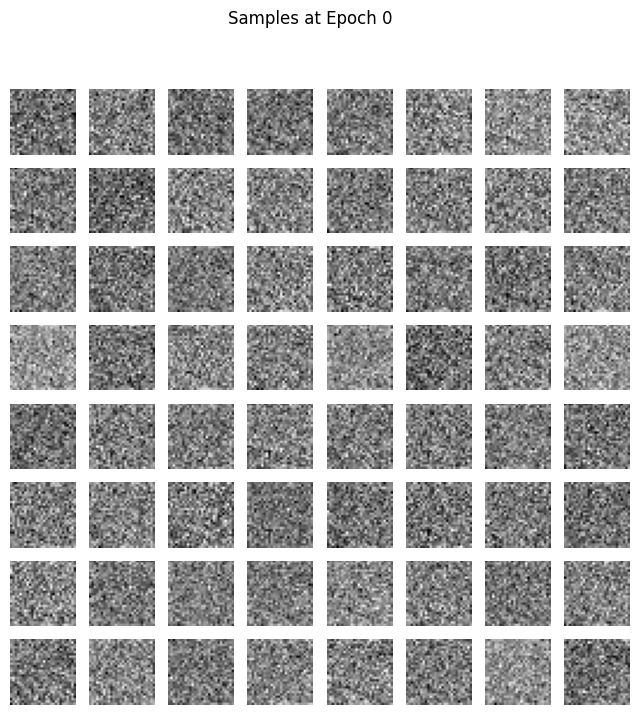

/wang/users/wluding/cluster_home/DL/myenv/lib/python3.9/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 159.41379166666667
Epoch 2, Loss: 109.01396735026042
Epoch 3, Loss: 100.10761883138021
Epoch 4, Loss: 96.13390118815104
Epoch 5, Loss: 93.62446362304688
Epoch 6, Loss: 91.90777355143229
Epoch 7, Loss: 90.58441067708333
Epoch 8, Loss: 89.6314407389323
Epoch 9, Loss: 88.75441901041667


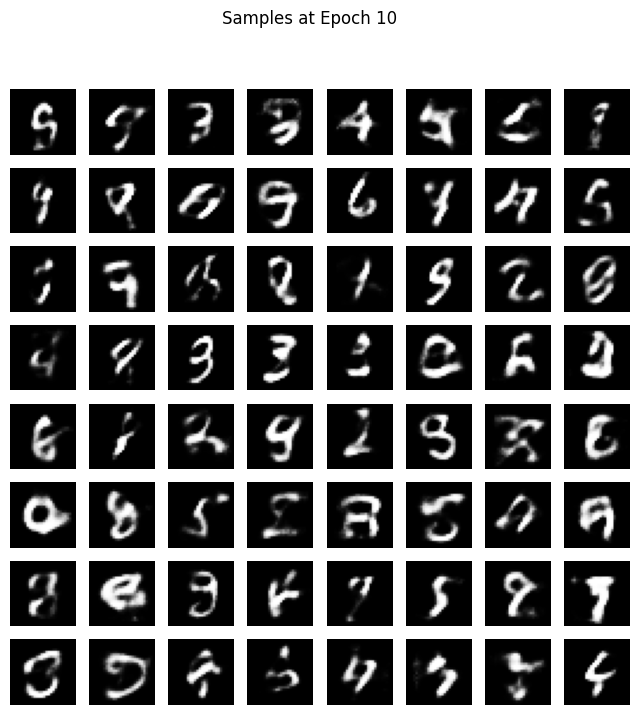

Epoch 10, Loss: 88.15899552408854
Epoch 11, Loss: 87.62036969401042
Epoch 12, Loss: 87.030865625
Epoch 13, Loss: 86.6559201171875
Epoch 14, Loss: 86.2151454671224
Epoch 15, Loss: 85.91658720703126
Epoch 16, Loss: 85.54343889973958
Epoch 17, Loss: 85.2675885172526
Epoch 18, Loss: 85.00966215006511
Epoch 19, Loss: 84.78975091145833
Epoch 20, Loss: 84.63854388834635
Epoch 21, Loss: 84.37287008463542
Epoch 22, Loss: 84.15514617513021
Epoch 23, Loss: 84.01834013671875
Epoch 24, Loss: 83.79147054036459
Epoch 25, Loss: 83.64871712239584
Epoch 26, Loss: 83.54640813802084
Epoch 27, Loss: 83.40585423177083
Epoch 28, Loss: 83.18219924316406
Epoch 29, Loss: 83.07990397949219
Epoch 30, Loss: 82.96643453776042
Epoch 31, Loss: 82.8226045735677
Epoch 32, Loss: 82.77511327311198
Epoch 33, Loss: 82.66058751627604
Epoch 34, Loss: 82.4702959798177
Epoch 35, Loss: 82.39248341471354
Epoch 36, Loss: 82.29615263671874
Epoch 37, Loss: 82.2444762858073
Epoch 38, Loss: 82.13498673502605
Epoch 39, Loss: 82.008391

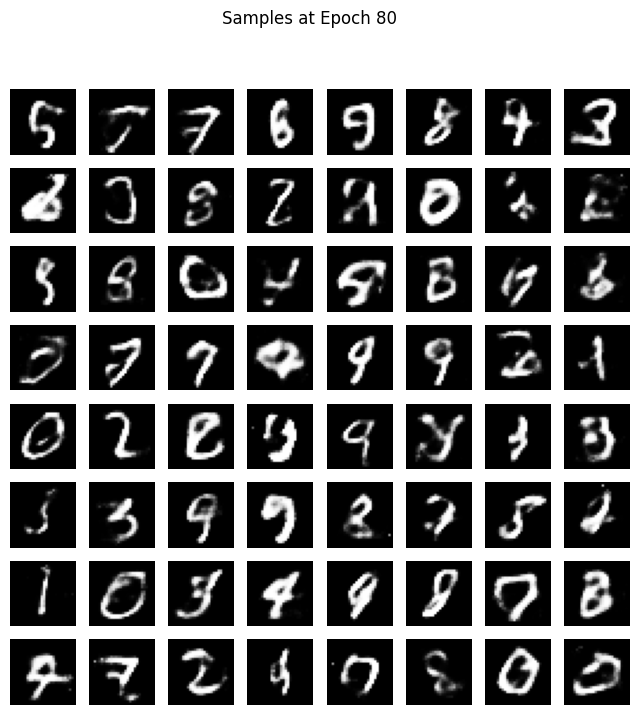

Epoch 80, Loss: 79.88124619140625


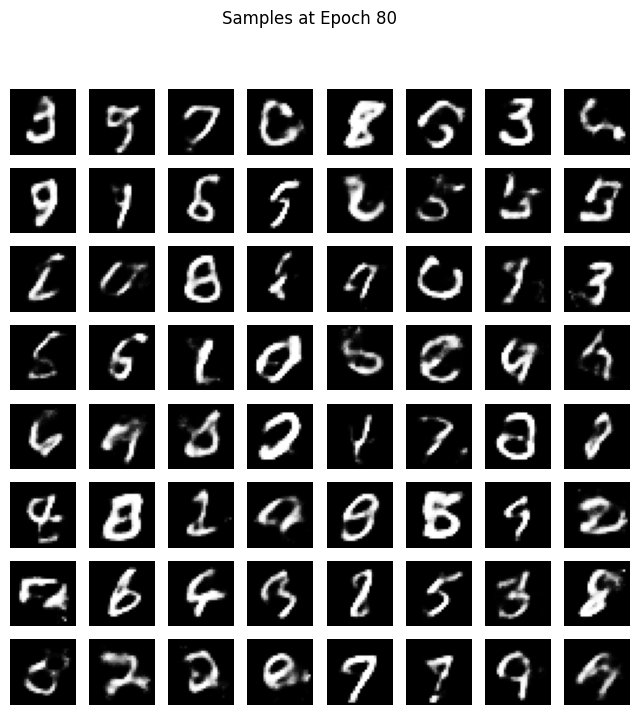

In [3]:
#import pyplot
import matplotlib.pyplot as plt

def plot_samples(vae, epoch, num_samples=64):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = vae.decoder(z).view(-1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Samples at Epoch {epoch}')
    plt.show()

# Plot initial samples before training
plot_samples(vae, epoch=0)# Load binarized MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).float()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training loop
num_epochs = 80
vae.train()
for epoch in range(1, num_epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    if epoch == 10 or epoch == 80:
        plot_samples(vae, epoch=epoch)
    
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

# Plot final samples after training
plot_samples(vae, epoch=num_epochs)

After running the code, you should observe the generated samples at three points: before training, after 10 epochs, and after 80 epochs. Here is a short analysis of the quality and issues of the generated images:

- Before Training: The initial samples are likely to be random noise, as the model has not yet learned any meaningful representations.
- After 10 Epochs: The samples should start to show some structure, but they may still be blurry or lack detail. The model is beginning to learn the underlying data distribution.
- After 80 Epochs: The samples should be much clearer and more detailed. The model has had sufficient time to learn the data distribution, and the generated images should resemble the training data more closely.

# 2. Diffusion

### Question 11 [4 points] 
Using $\log p(x) = \log(\int p(x, z_{1:T} )dz_{1:T} )$, extend the ELBO formula for Markovian Hierarchical Variational Autoencoder to obtain : 
$$\log p(x) \geq E_{q_{\phi}(z_{1:T} |x)} \left[\log \frac{p(x,z_{1:T} )}{q_{\phi}(z_{1:T} |x)}\right]$$

*Response:* Using the definition of KL divergence, we see that 
$$\log p(x) = E_{q_{\phi}(z_{1:T} |x)} \left[\log \frac{p(x,z_{1:T} )}{q_{\phi}(z_{1:T} |x)}\right] + \text{KL}(q_{\phi}(z_{1:T} |x)||p_{\theta}(z_{1:T} |x))\\
= E_{q_{\phi}(z_{1:T} |x)} \left[\log \frac{p(x,z_{1:T} )}{p_{\theta}(z_{1:T} |x)}\right]\\
= E_{q_{\phi}(z_{1:T} |x)} \left[\log p(x)\right]
$$

### Question 12 [4 points] 
Based on these 3 restrictions, describe in a few lines the process (architecture, transformations, inputs and outputs).

*Response*: 
- Architecture: Since each step of the diffusion process has the same dimension, we can reuse the same architecture with same input and output dimension and an additional input for time step to define the reverse diffusion process.
- The forward transformation is simply a scaling of the input and an addition of Gaussian noise with an amplitude determined by the noising schedule.
- The input of the forward process is an image, and the output is a significantly noised and rescaled version of that image
- The input of the backwards process in standard Gaussian noise, and the output is an image resembling an image in the dataset.

### Question 13 [3 points]

Comment on the several terms of the formula in eq. 24. What is the role of each of these terms in the ELBO formula?

*Response*
- Reconstruction Term: This term simply ensures that our final decoder layer, which is different from the others since $\log p_{\theta} (z_0|z_1)$ must be a discrete distribution, has a good distribution for the final denoised image that puts high likelihood on real images when conditioned on their noised versions.  
- Prior Matching Term: This term says that our total denoising process should result in $z_T$ being as close to our prior $P(z_T)$ of pure Gaussian noise as possible.
- Consistency Terms: These terms ensure that our Gaussian denoisers $p_{\theta}(z_t|z_{t+1})$ are good models for the noising process $q_{\phi}(z_t|z_{t-1}).



### Question 14 [4 points] 
Using the reparametrization trick and eq. 23, we can write that:
$$z_t = \sqrt{\alpha_t} z_{t−1} + \sqrt{1 − \alpha_t} \epsilon$$
 with $\epsilon ~ N (\epsilon; 0, I)$$
Show that z_t follow a distribution that can be written as eq. 26.
$$z_t ∼ N (z_{t-1}; \sqrt{\bar{\alpha}_t}z_0, (1 − \bar{\alpha})I)

*Response:*  We proceed with proof by induction: It can be seen using formula 25 directly that the base case 
$t=1$ holds.

For the inductive step, we note that if 
$$z_t = \sqrt{\bar{\alpha_t} z_{0}} + \sqrt{1 − \bar{\alpha_t}} \epsilon$$
then
$$z_{t+1} = \sqrt{\bar{\alpha}_{t+1}} z_{0} + \sqrt{\alpha_{t+1}} \sqrt{1 − \bar{\alpha_t}} \epsilon + \sqrt{1-\alpha_{t+1}} \epsilon'\\
= \sqrt{\bar{\alpha}_{t+1}} z_{0} + \sqrt{\alpha_{t+1} − \bar{\alpha}_{t+1} + 1-\alpha_{t+1}} \epsilon\\
= \sqrt{\bar{\alpha}_{t+1}} z_{0} + \sqrt{1 − \bar{\alpha}_{t+1} } \epsilon
$$

### Question 15 [4 points] 
Plug equations 29 and 30 in equation 28 and find an interpretation to the final optimization term.

*response:* plugging in gives us 
$$\arg \min_{\theta} D_{\text{KL}} (q(z_{t−1}|z_t, z_0)||p\theta (z_{t−1}|z_t)) = \arg \min_{\theta} \frac{\bar{\alpha}_{t-1} (1-\alpha_t)^2}{2\sigma_q^2(t)(1-\bar{\alpha_t})^2}||z_0-\hat{z_{\theta}}(z_t, t)||^2$$

With this parameterization, one can think of the final optimization term as forcing the network to learn a good approximation of the added Gaussian noise depending on the noised image $z_t$ and the timestep $t$.

### Question 16 [4 points] 
Recall that $q(z_t|z_0) is a Gaussian of form $N (z_t; \sqrt{\bar{\alpha}_t}z_0,(1 − \bar{\alpha}_t)I). Then, following the definition
of the signal-to-noise ratio (SNR) as $\text{SNR} = \frac{\mu^2}{\sigma^2} , deduce the SNR at timestep $t$.

Given this, we have $\text{SNR} = \frac{\bar{\alpha}}{1-\bar{\alpha}} z_0^{\top}z_0$



### Question 17 [4 points] 
Introduce the SNR into the equation that you got at Question 15 (recall that $\sigma^2_q(t) = \frac{(1−\alpha_t) (1−\bar{\alpha}_{t−1})}{1−\bar{\alpha}_t}$.)
What does it mean for our diffusion model? Link it to the definition of the SNR.

*Response:* Plugging in the definition of $\sigma^2_q(t)$ and SNR to the equation derived in question 15 gives that 
$$\arg \min_{\theta} D_{\text{KL}} (q(z_{t−1}|z_t, z_0)||p\theta (z_{t−1}|z_t)) = \arg \min_{\theta} \frac{\text{SNR}_{t-1} (1-\alpha_t)}{2(1-\bar{\alpha_t})}||z_0-\hat{z_{\theta}}(z_t, t)||^2$$

This means for the diffusion model that...

## 2.2 Diffusion in Practice

### Question 18 [4 points] 
The reverse diffusion process (ie. generating an image from noise) can be applied with multiple
ways of sampling the denoised image at each timestep t. For example it is possible to skip some timesteps to fasten the generation process, or to change the amount of noise added to an image to a different schedule to reduce the variations at the end of the diffusion process. The goal is to look at the practical details of diffusion by changing the scheduler when generating an image.

Find a way to generate images with the same seed but with different number of steps and different kind of noise schedulers. Plot a grid of generated images with different number of steps as rows and different schedulers as columns (use at least three schedulers including Euler, Euler Ancestral and DPM). What can you say about the differences between schedulers? What is the impact of the number of steps?

Hint: you can look at the tutorial https://huggingface.co/docs/diffusers/using-diffusers/schedulers.

In [1]:
import torch
from diffusers import DiffusionPipeline, DDIMScheduler, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler
import matplotlib.pyplot as plt


In [2]:
torch.backends.nnpack.enabled = False

# Define the schedulers
schedulers = {
    'DDIM': DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler"),
    'Euler': EulerDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler"),
    'Euler Ancestral': EulerAncestralDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler"),
    'DPM': DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
}

# Load the pipeline
pipeline = DiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16, use_safetensors=True
)

prompt = "A photograph of an astronaut riding a horse on Mars, high resolution, high definition."
generator = torch.Generator(device="cpu").manual_seed(8)

# Generate images
def generate_images(pipeline, schedulers, steps_list, prompt, generator):
    images = {}
    for name, scheduler in schedulers.items():
        images[name] = []
        for steps in steps_list:
            print(steps)
            scheduler.set_timesteps(steps)
            pipeline.scheduler = scheduler
            with torch.no_grad():
                image = pipeline(prompt, num_inference_steps=steps, generator=generator).images[0]
            images[name].append(image)
    return images

# Plot the grid
def plot_grid(images, steps_list):
    fig, axes = plt.subplots(len(steps_list), len(images), figsize=(10, 10))
    for i, steps in enumerate(steps_list):
        for j, (name, imgs) in enumerate(images.items()):
            axes[i, j].imshow(imgs[i])
            if i == 0:
                axes[i, j].set_title(name)
            if j == 0:
                axes[i, j].set_ylabel(f'Steps: {steps}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Parameters
steps_list = [10, 20, 50, 100]

# Generate and plot images
images = generate_images(pipeline, schedulers, steps_list, prompt, generator)
plot_grid(images, steps_list)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

[W105 07:41:08.266023583 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


KeyboardInterrupt: 

### Question 19 [4 points]
Use a pre-trained diffusion model that can be guided by a textual prompt and generate an image
with a given prompt (eg. ‘a photograph of an astronaut riding a horse’). Guidance can also be used in a negative manner
to remove something from generated images (eg. hands with 6 fingers, bad weather, undesired objects...).

Using the same initial noise and prompt as before, find a way to remove an object/a color/a concept that is present in
your generated image but not in your prompt (e.g. if you generate an image without specifying the background and you
get a desert but you want something else, remove the desert by using a negative prompt ‘desert’ like in Fig. 2).

Plot the two images side by side, along with their prompt/negative prompt, and write a small paragraph analyzing
them. What can you say about the position of the object?

Hint: you can use the Diffusers library and modify the line
`noise pred = noise pred uncond + guidance scale *
(noise_pred_text−noisepreduncond)`
in the section ‘Deconstruct the Stable Diffusion pipeline’ from the previous url.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import matplotlib.pyplot as plt

# Load the pre-trained diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# Define the prompts
prompt = "A photograph of an astronaut riding a horse on Mars, high resolution, high definition."
negative_prompt = "desert"

# Set the generator for reproducibility
generator = torch.Generator(device="cuda").manual_seed(8)

# Generate image with the prompt
image_with_prompt = pipeline(prompt, num_inference_steps=50, generator=generator).images[0]

# Generate image with the prompt and negative prompt
image_with_negative_prompt = pipeline(prompt, negative_prompt=negative_prompt, num_inference_steps=50, generator=generator).images[0]

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_with_prompt)
axes[0].set_title("Prompt: " + prompt)
axes[0].axis('off')

axes[1].imshow(image_with_negative_prompt)
axes[1].set_title("Prompt: " + prompt + "\nNegative Prompt: " + negative_prompt)
axes[1].axis('off')

plt.tight_layout()
plt.show()


# 3. Multilingual Translation

## 3.1 Prenormalization

### Question 20. [13 points] 
Derive analytically the impact of that different sequence of layers, when doing back-propagation during training. (Hint: If you denote by $e$ the error produced in one pass, and $x_L$ the top-most layer, then by applying chain rule you obtain:)
$$ \frac{\partial e }{\partial x_l}= \frac{\partial e}{\partial x_L} \frac{\partial x_L}{\partial x_l}$$
Derive then $\frac{\partial x_{l+1}}{\partial x_l}$. (no need of actually deriving $\frac{\partial LayerNorm(x)}{\partial x}$ ).

$$ \frac{\partial e }{\partial x_l}= \frac{\partial e}{\partial x_L} \Pi_{k=l}^{L-1}\frac{\partial x_{k+1}}{\partial x_k}$$

For eq 31, this gives

$$ \frac{\partial e }{\partial x_l}= \frac{\partial e}{\partial x_L} \Pi_{k=l}^{L-1}\left(LayerNorm'(x_k+A(x_l))(1+A'(x_l))\right)$$

For eq 32, this gives 

$$ \frac{\partial e }{\partial x_l}= \frac{\partial e}{\partial x_L} \Pi_{k=l}^{L-1}\left(1 + A'(LayerNorm(x_k))LayerNorm'(x_k)\right)$$


### Question 21. [8.5 points] 
Explain in a few paragraphs what do you think are the consequences of training (very deep
models) of those derivations when using Eq 32 instead of Eq. 31?

For very deep networks, it seems that the gradient might be easier to control, so that it could be easier to avoid the problem of vanishing or exploding gradients.


When training deep transformer blocks, the placement of Layer Normalization (LayerNorm) can significantly impact the model's performance and stability. Here are the differences between applying LayerNorm before the attention layer and applying it last to the updated embeddings:

### Applying LayerNorm Before the Attention Layer

This approach is often referred to as **Pre-LayerNorm**. In this setup, LayerNorm is applied to the input embeddings before they are fed into the attention layer and the feed-forward network.

**Advantages:**
1. **Stabilizes Training**: Pre-LayerNorm can help stabilize training, especially in very deep transformer models, by normalizing the input to each layer, which can prevent the gradients from exploding or vanishing.
2. **Improved Gradient Flow**: By normalizing the inputs to the attention and feed-forward layers, it can improve the gradient flow through the network, making it easier to train deeper models.

**Disadvantages:**
1. **Potentially Slower Convergence**: In some cases, Pre-LayerNorm can lead to slower convergence compared to Post-LayerNorm.

### Applying LayerNorm Last to the Updated Embeddings

This approach is often referred to as **Post-LayerNorm**. In this setup, LayerNorm is applied to the output of the attention layer and the feed-forward network, after the residual connections have been added.

**Advantages:**
1. **Faster Convergence**: Post-LayerNorm can sometimes lead to faster convergence during training.
2. **Direct Residual Learning**: By applying LayerNorm after the residual connections, the model can directly learn the residuals, which can be beneficial for certain tasks.

**Disadvantages:**
1. **Training Instability**: Post-LayerNorm can sometimes lead to training instability, especially in very deep transformer models, as the inputs to each layer are not normalized, which can cause issues with gradient flow.





### Question 22. [8.5 points] 
Show empirically the impact of this. This is, design a measure and plot that measure against
training steps for a standard task (eg: language modelling), comparing those plots between a deep and shallow model.
Finding what exactly to measure is an important part of the problem.

In [ ]:
import torch
import torch.nn as nn

class TransformerBlockPreLayerNorm(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlockPreLayerNorm, self).__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

    def forward(self, x):
        x = self.layernorm1(x)
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.layernorm2(x)
        ff_output = self.feed_forward(x)
        x = x + ff_output
        return x

class TransformerBlockPostLayerNorm(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlockPostLayerNorm, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.layernorm1(x)
        ff_output = self.feed_forward(x)
        x = x + ff_output
        x = self.layernorm2(x)
        return x

To empirically show the difference between Pre-LayerNorm and Post-LayerNorm, you can design an experiment that measures and compares the training stability and convergence speed of both normalization strategies on a standard task like language modeling. Here's a step-by-step guide to achieve this:

1. **Define the Experiment**:
   - Use a standard language modeling dataset (e.g., WikiText-2).
   - Implement both Pre-LayerNorm and Post-LayerNorm transformer models.
   - Train both models on the dataset.
   - Measure training loss and validation loss over training steps.

2. **Implement the Models**:
   - Implement transformer models with Pre-LayerNorm and Post-LayerNorm.
   - Implement both shallow and deep versions of these models.

3. **Train the Models**:
   - Train the models and log the training and validation loss at regular intervals.

4. **Plot the Results**:
   - Plot the training and validation loss against training steps for both normalization strategies.
   - Compare the plots for shallow and deep models.

Here's an example implementation:

### Step 1: Define the Experiment



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Define the dataset and data loader
tokenizer = get_tokenizer('basic_english')
train_iter = WikiText2(split='train')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def data_process(raw_text_iter):
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_data = data_process(WikiText2(split='train'))
val_data = data_process(WikiText2(split='valid'))

class WikiTextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) // self.seq_len

    def __getitem__(self, idx):
        start = idx * self.seq_len
        end = start + self.seq_len + 1
        return self.data[start:end]

seq_len = 35
batch_size = 20

train_dataset = WikiTextDataset(train_data, seq_len)
val_dataset = WikiTextDataset(val_data, seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



### Step 2: Implement the Models



In [ ]:
class TransformerBlockPreLayerNorm(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlockPreLayerNorm, self).__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

    def forward(self, x):
        x = self.layernorm1(x)
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.layernorm2(x)
        ff_output = self.feed_forward(x)
        x = x + ff_output
        return x

class TransformerBlockPostLayerNorm(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlockPostLayerNorm, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.layernorm1(x)
        ff_output = self.feed_forward(x)
        x = x + ff_output
        x = self.layernorm2(x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, pre_layer_norm=True):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([
            TransformerBlockPreLayerNorm(embed_dim, num_heads, ff_dim) if pre_layer_norm else TransformerBlockPostLayerNorm(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.fc(x)
        return x



### Step 3: Train the Models



In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        data, targets = batch[:, :-1].to(device), batch[:, 1:].to(device)
        output = model(data)
        loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            data, targets = batch[:, :-1].to(device), batch[:, 1:].to(device)
            output = model(data)
            loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

def run_experiment(embed_dim, num_heads, ff_dim, num_layers, pre_layer_norm, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel(len(vocab), embed_dim, num_heads, ff_dim, num_layers, pre_layer_norm).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Parameters
embed_dim = 128
num_heads = 4
ff_dim = 512
epochs = 10

# Shallow model
num_layers_shallow = 2
train_losses_pre_shallow, val_losses_pre_shallow = run_experiment(embed_dim, num_heads, ff_dim, num_layers_shallow, pre_layer_norm=True, epochs=epochs)
train_losses_post_shallow, val_losses_post_shallow = run_experiment(embed_dim, num_heads, ff_dim, num_layers_shallow, pre_layer_norm=False, epochs=epochs)

# Deep model
num_layers_deep = 6
train_losses_pre_deep, val_losses_pre_deep = run_experiment(embed_dim, num_heads, ff_dim, num_layers_deep, pre_layer_norm=True, epochs=epochs)
train_losses_post_deep, val_losses_post_deep = run_experiment(embed_dim, num_heads, ff_dim, num_layers_deep, pre_layer_norm=False, epochs=epochs)



### Step 4: Plot the Results



In [ ]:
def plot_results(train_losses_pre, val_losses_pre, train_losses_post, val_losses_post, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses_pre, label='Train Loss (Pre-LayerNorm)')
    plt.plot(val_losses_pre, label='Val Loss (Pre-LayerNorm)')
    plt.plot(train_losses_post, label='Train Loss (Post-LayerNorm)')
    plt.plot(val_losses_post, label='Val Loss (Post-LayerNorm)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot results for shallow model
plot_results(train_losses_pre_shallow, val_losses_pre_shallow, train_losses_post_shallow, val_losses_post_shallow, 'Shallow Model (2 Layers)')

# Plot results for deep model
plot_results(train_losses_pre_deep, val_losses_pre_deep, train_losses_post_deep, val_losses_post_deep, 'Deep Model (6 Layers)')



### Analysis

After running the experiments and plotting the results, you can analyze the differences between Pre-LayerNorm and Post-LayerNorm for both shallow and deep models. Here are some points to consider:

- **Training Stability**: Observe if one normalization strategy leads to more stable training, especially in the deep model.
- **Convergence Speed**: Compare the speed of convergence for both strategies.
- **Final Performance**: Evaluate the final training and validation loss to see which strategy performs better.

By comparing these plots, you can empirically demonstrate the differences between Pre-LayerNorm and Post-LayerNorm in terms of training stability and convergence speed for both shallow and deep transformer models.

Similar code found with 2 license types